# House sales prices in King County

A project on exploratory data analysis.

Sebastian Thomas @ neue fische Bootcamp Data Science<br />
(datascience at sebastianthomas dot de)

# Part 5: Predictive analysis

We fit some predictive models on our preprocessed data.

## Imports

### Modules, classes and functions

In [1]:
# import of modules
from importlib import import_module

# object persistence
import joblib

# data
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt

# machine learning
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, Normalizer, OneHotEncoder, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer
from xgboost import XGBRegressor

# custom modules
from modules.ds import root_mean_squared_error, median_absolute_error, mean_absolute_percentage_error

### Helpers

Some helping functions to evaluate our regression models.

In [2]:
def print_evaluation(regressor, X_train, X_test, y_train, y_test):
    print('R^2:   {:.3f}, {:.3f}'.format(r2_score(y_train, regressor.predict(X_train)),
                                         r2_score(y_test, regressor.predict(X_test))))
    print('RMSE:  {:.0f}, {:.0f}'.format(root_mean_squared_error(y_train, regressor.predict(X_train)),
                                         root_mean_squared_error(y_test, regressor.predict(X_test))))
    print('MAE:   {:.0f}, {:.0f}'.format(mean_absolute_error(y_train, regressor.predict(X_train)),
                                         mean_absolute_error(y_test, regressor.predict(X_test))))
    print('MedAE: {:.0f}, {:.0f}'.format(median_absolute_error(y_train, regressor.predict(X_train)),
                                         median_absolute_error(y_test, regressor.predict(X_test))))
    print('MAPE:  {:.3f}, {:.3f}'.format(mean_absolute_percentage_error(y_train, regressor.predict(X_train)),
                                         mean_absolute_percentage_error(y_test, regressor.predict(X_test))))

### Data

We import the preprocessed data.

In [3]:
houses_train = pd.read_pickle('data/king_county_train_2_engineered.pickle')
houses_train.sample(5, random_state=0)

,price,date,month,sqft_living,sqft_living log,sqft_above,sqft_above log,sqft_basement,has_basement,room_size,...,long,zipcode,zipcode cat,condition,condition bin,grade,grade bin,view,view bin,waterfront
id,,,,,,,,,,,,,,,,,,,,,
8724300010,548000.0,2014-09-09,2014-09,3420.0,8.137688,2330.0,7.754053,1090.0,True,414.545455,...,-121.982,98019,2,3,3 to 4,10,10,0,0,False
1423400005,249950.0,2014-08-15,2014-08,1370.0,7.223296,1370.0,7.223296,0.0,False,274.000000,...,-122.182,98058,1,4,3 to 4,6,3 to 6,0,0,False
7202330280,401000.0,2014-09-22,2014-09,1350.0,7.208600,1350.0,7.208600,0.0,False,216.000000,...,-122.036,98053,4,3,3 to 4,7,7,0,0,False
1828000230,498000.0,2014-07-14,2014-07,1620.0,7.390799,1180.0,7.074117,440.0,True,270.000000,...,-122.128,98052,4,3,3 to 4,7,7,0,0,False
3342100995,449000.0,2014-10-22,2014-10,1980.0,7.591357,1980.0,7.591357,0.0,False,264.000000,...,-122.207,98056,1,3,3 to 4,8,8,0,0,False


## Preparation

In [4]:
y_train = houses_train['price'].values

In [5]:
houses_fit, houses_valid, y_fit, y_valid = train_test_split(houses_train, y_train, test_size=0.1, random_state=0)

## Rough analysis

We start with a rough analysis.

### Dummy approach

As a baseline approach, we predict by the median.

In [6]:
X_fit = np.empty((y_fit.size, 1))
X_valid = np.empty((y_valid.size, 1))

In [7]:
dummy_regressor = DummyRegressor(strategy='median')
dummy_regressor.fit(X_fit, y_fit);
print_evaluation(dummy_regressor, X_fit, X_valid, y_fit, y_valid)

R^2:   -0.062, -0.065
RMSE:  376836, 393670
MAE:   222420, 222612
MedAE: 150000, 148000
MAPE:  0.423, 0.409


### Basic approach with `'sqft_living log'`

Next, we do some basic linear approaches. We start with just the feature `'sqft_living log'` (logarithm of living space area).

In [8]:
X_fit = houses_fit[['sqft_living log']]
X_valid = houses_valid[['sqft_living log']]

In [9]:
# with sklearn
linear_regressor = LinearRegression()
linear_regressor.fit(X_fit, y_fit);
print_evaluation(linear_regressor, X_fit, X_valid, y_fit, y_valid)

R^2:   0.375, 0.372
RMSE:  289150, 302283
MAE:   188190, 184524
MedAE: 144977, 136775
MAPE:  0.405, 0.386


In [10]:
# with statsmodels
linear_regressor = OLS(y_fit, add_constant(X_fit))
results = linear_regressor.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     8665.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        23:35:13   Log-Likelihood:            -2.0232e+05
No. Observations:               14458   AIC:                         4.046e+05
Df Residuals:                   14456   BIC:                         4.047e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -3.449e+06   4.29e+04    -80.339      0.000   -3.53e+06   -3.36e+06
sqft_living log  5.281e+05   5673.530     93.088      0.000    5.17e+05    5.39e+05
==============================================================================
Omnibus:                    12921.107   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1139262.900
Skew:                           3.928   Prob(JB):                         0.00
Kurtosis:                      45.772   Cond. No.                         137.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Basic approach with `'sqft_living log'`, `'sqft_lot'`, `'lat'`, `'long'`

We add the features `'sqft_lot'` (lot space), `'lat'` (lattitude) and `'long'` (longitude).

In [11]:
X_fit = houses_fit[['sqft_living log', 'sqft_lot', 'lat', 'long']]
X_valid = houses_valid[['sqft_living log', 'sqft_lot', 'lat', 'long']]

In [12]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_fit, y_fit);
print_evaluation(linear_regressor, X_fit, X_valid, y_fit, y_valid)

R^2:   0.469, 0.453
RMSE:  266578, 282121
MAE:   164509, 163007
MedAE: 118236, 117162
MAPE:  0.342, 0.331


In [13]:
linear_regressor = OLS(y_fit, add_constant(X_fit))
results = linear_regressor.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     3186.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        23:35:13   Log-Likelihood:            -2.0114e+05
No. Observations:               14458   AIC:                         4.023e+05
Df Residuals:                   14453   BIC:                         4.023e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -7.431e+07   2.11e+06    -35.138      0.000   -7.85e+07   -7.02e+07
sqft_living log  5.381e+05   5445.604     98.813      0.000    5.27e+05    5.49e+05
sqft_lot            0.4251      0.053      8.062      0.000       0.322       0.528
lat              7.216e+05   1.62e+04     44.595      0.000     6.9e+05    7.53e+05
long            -2.983e+05   1.69e+04    -17.668      0.000   -3.31e+05   -2.65e+05
==============================================================================
Omnibus:                    14371.403   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1858373.110
Skew:                           4.570   Prob(JB):                         0.00
Kurtosis:                      57.784   Cond. No.                     4.40e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.4e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Ordinary approach with `LinearRegression`

In the next approaches, we will work with more features.

In [14]:
houses_train.columns

Index(['price', 'date', 'month', 'sqft_living', 'sqft_living log',
       'sqft_above', 'sqft_above log', 'sqft_basement', 'has_basement',
       'room_size', 'room_size log', 'base_area', 'base_area log', 'sqft_lot',
       'sqft_living15', 'sqft_living15 log', 'sqft_lot15', 'bedrooms',
       'bedrooms bin', 'bathrooms', 'bathrooms bin', 'bathrooms_ratio',
       'bathrooms_ratio bin', 'floors', 'floors bin', 'yr_built',
       'decade_built', 'yr_built bin', 'yr_renovated', 'is_renovated', 'lat',
       'long', 'zipcode', 'zipcode cat', 'condition', 'condition bin', 'grade',
       'grade bin', 'view', 'view bin', 'waterfront'],
      dtype='object')

In [15]:
numerical_features = ['sqft_living log', 'base_area log', 'sqft_lot', 'lat', 'long']
categorical_features = ['bedrooms bin', 'bathrooms bin', 'bathrooms_ratio bin', 'floors bin', 'yr_built bin', 
                        'zipcode cat', 'condition bin', 'grade bin', 'view bin']
boolean_features = ['has_basement', 'is_renovated', 'waterfront']

In [16]:
column_transformer = ColumnTransformer([
    ('numericals_transformer', StandardScaler(), numerical_features),
    ('categoricals_transformer', OneHotEncoder(drop='first'), categorical_features),
    ('booleans_transformer', 'passthrough', boolean_features)
], n_jobs=-1)

X_fit = column_transformer.fit_transform(houses_fit)
X_valid = column_transformer.transform(houses_valid)

In [17]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_fit, y_fit)
print_evaluation(linear_regressor, X_fit, X_valid, y_fit, y_valid)

R^2:   0.831, 0.768
RMSE:  150453, 183818
MAE:   91411, 94884
MedAE: 60081, 57901
MAPE:  0.177, 0.175


In [18]:
linear_regressor = OLS(y_fit, add_constant(X_fit.toarray()))
results = linear_regressor.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     1334.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        23:35:15   Log-Likelihood:            -1.9287e+05
No. Observations:               14458   AIC:                         3.859e+05
Df Residuals:                   14404   BIC:                         3.863e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.323e+05   7.89e+04      8.018      0.000    4.78e+05    7.87e+05
x1          7.405e+04   9091.486      8.145      0.000    5.62e+04    9.19e+04
x2          1.951e+04   8826.793      2.210      0.027    2208.616    3.68e+04
x3          8225.2209   1334.120      6.165      0.000    5610.173    1.08e+04
x4          2.539e+04   2130.881     11.913      0.000    2.12e+04    2.96e+04
x5         -2.387e+04   1703.360    -14.013      0.000   -2.72e+04   -2.05e+04
x6         -1.219e+04   1.63e+04     -0.748      0.454   -4.41e+04    1.97e+04
x7         -1.035e+04    1.9e+04     -0.546      0.585   -4.76e+04    2.68e+04
x8         -2.264e+04   2.04e+04     -1.110      0.267   -6.26e+04    1.74e+04
x9         -3.044e+04   2.24e+04     -1.361      0.173   -7.43e+04    1.34e+04
x10        -7.667e+04   2.57e+04     -2.988      0.003   -1.27e+05   -2.64e+04
x11         1.924e+04   7.57e+04      0.254      0.799   -1.29e+05    1.68e+05
x12         -868.2025   7.66e+04     -0.011      0.991   -1.51e+05    1.49e+05
x13         1.941e+04   7.72e+04      0.252      0.801   -1.32e+05    1.71e+05
x14         9.842e+04   7.79e+04      1.264      0.206   -5.42e+04    2.51e+05
x15         1.953e+05   7.85e+04      2.489      0.013    4.15e+04    3.49e+05
x16         5.558e+05   8.15e+04      6.820      0.000    3.96e+05    7.16e+05
x17         2.516e+06   1.24e+05     20.293      0.000    2.27e+06    2.76e+06
x18         1.371e+04   8907.656      1.539      0.124   -3748.091    3.12e+04
x19         1.562e+04   1.13e+04      1.386      0.166   -6472.610    3.77e+04
x20         7612.1944   1.32e+04      0.578      0.563   -1.82e+04    3.34e+04
x21         3322.1294   1.88e+04      0.177      0.860   -3.35e+04    4.02e+04
x22        -5.011e+04   5.21e+04     -0.961      0.337   -1.52e+05    5.21e+04
x23         2.456e+04   1.25e+04      1.968      0.049     102.411     4.9e+04
x24         1.275e+05   2.36e+04      5.401      0.000    8.12e+04    1.74e+05
x25          1.17e+04   2.24e+04      0.522      0.601   -3.22e+04    5.56e+04
x26        -6.538e+04   4711.110    -13.877      0.000   -7.46e+04   -5.61e+04
x27        -9.697e+04   5644.136    -17.180      0.000   -1.08e+05   -8.59e+04
x28        -1.227e+05   7836.165    -15.655      0.000   -1.38e+05   -1.07e+05
x29        -1.148e+05   8468.126    -13.551      0.000   -1.31e+05   -9.82e+04
x30        -6.829e+04   1.03e+04     -6.650      0.000   -8.84e+04   -4.82e+04
x31         5.401e+04   4614.921     11.704      0.000     4.5e+04    6.31e+04
x32         1.124e+05   6464.667     17.390      0.000    9.97e+04    1.25e+05
x33         1.957e+05   5998.199     32.632      0.000    1.84e+05    2.07e+05
x34         2.208e+05   7588.750     29.091      0.000    2.06e+05    2.36e+05
x35         2.826e+05   6814.830     41.470      0.000    2.69e+05    2.96e+05
x3

### Approach with `PolynomialFeatures`

In [19]:
polynomial_regressor = make_pipeline(PolynomialFeatures(), LinearRegression())
polynomial_regressor.fit(X_fit, y_fit);
print_evaluation(polynomial_regressor, X_fit, X_valid, y_fit, y_valid)

R^2:   0.927, 0.813
RMSE:  98616, 164738
MAE:   65639, 83548
MedAE: 44544, 46349
MAPE:  0.135, 0.149


### Logarithmic approach

In [20]:
linear_regressor = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log, inverse_func=np.exp)
linear_regressor.fit(X_fit, y_fit)
print_evaluation(linear_regressor, X_fit, X_valid, y_fit, y_valid)

R^2:   0.867, 0.871
RMSE:  133157, 136845
MAE:   78836, 80706
MedAE: 49363, 48743
MAPE:  0.147, 0.144


In [21]:
linear_regressor = OLS(np.log(y_fit), add_constant(X_fit.toarray()))
results = linear_regressor.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     1732.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        23:35:31   Log-Likelihood:                 3221.6
No. Observations:               14458   AIC:                            -6335.
Df Residuals:                   14404   BIC:                            -5926.
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6453      0.101    124.595      0.000      12.446      12.844
x1             0.1368      0.012     11.691      0.000       0.114       0.160
x2             0.0528      0.011      4.643      0.000       0.030       0.075
x3             0.0300      0.002     17.484      0.000       0.027       0.033
x4             0.0583      0.003     21.246      0.000       0.053       0.064
x5            -0.0435      0.002    -19.847      0.000      -0.048      -0.039
x6             0.0057      0.021      0.271      0.787      -0.035       0.047
x7             0.0182      0.024      0.743      0.457      -0.030       0.066
x8             0.0102      0.026      0.389      0.697      -0.041       0.062
x9            -0.0068      0.029     -0.236      0.814      -0.063       0.050
x10           -0.0269      0.033     -0.815      0.415      -0.092       0.038
x11            0.1774      0.097      1.821      0.069      -0.014       0.368
x12            0.1400      0.099      1.420      0.155      -0.053       0.333
x13            0.1594      0.099      1.606      0.108      -0.035       0.354
x14            0.2077      0.100      2.072      0.038       0.011       0.404
x15            0.2444      0.101      2.420      0.016       0.046       0.442
x16            0.2842      0.105      2.709      0.007       0.079       0.490
x17            0.2352      0.160      1.474      0.141      -0.078       0.548
x18            0.0579      0.011      5.047      0.000       0.035       0.080
x19            0.0697      0.015      4.808      0.000       0.041       0.098
x20            0.0686      0.017      4.051      0.000       0.035       0.102
x21            0.0625      0.024      2.585      0.010       0.015       0.110
x22            0.0198      0.067      0.296      0.767      -0.112       0.151
x23            0.0685      0.016      4.268      0.000       0.037       0.100
x24            0.1240      0.030      4.081      0.000       0.064       0.184
x25            0.0575      0.029      1.995      0.046       0.001       0.114
x26           -0.1178      0.006    -19.435      0.000      -0.130      -0.106
x27           -0.1595      0.007    -21.958      0.000      -0.174      -0.145
x28           -0.1698      0.010    -16.839      0.000      -0.190      -0.150
x29           -0.1723      0.011    -15.805      0.000      -0.194      -0.151
x30           -0.0962      0.013     -7.282      0.000      -0.122      -0.070
x31            0.1815      0.006     30.563      0.000       0.170       0.193
x32            0.3240      0.008     38.941      0.000       0.308       0.340
x33            0.4988      0.008     64.610      0.000       0.484       0.514
x34            0.5212      0.010     53.365      0.000       0.502       0.540
x35            0.6067      0.009     69.176      0.000       0.590       0.624
x3

### Logarithmic approach with `PolynomialFeatures`

In [22]:
polynomial_regressor = TransformedTargetRegressor(regressor=make_pipeline(PolynomialFeatures(),
                                                                          LinearRegression()),
                                                  func=np.log, inverse_func=np.exp)
polynomial_regressor.fit(X_fit, y_fit)
print_evaluation(polynomial_regressor, X_fit, X_valid, y_fit, y_valid)

R^2:   0.927, 0.628
RMSE:  98518, 232583
MAE:   62987, 83419
MedAE: 41282, 42661
MAPE:  0.124, 0.138


### Logarithmic approach with `SVR`

In [23]:
support_vector_regressor = TransformedTargetRegressor(regressor=SVR(), func=np.log, inverse_func=np.exp)
support_vector_regressor.fit(X_fit, y_fit)
print_evaluation(support_vector_regressor, X_fit, X_valid, y_fit, y_valid)

R^2:   0.935, 0.835
RMSE:  93281, 154721
MAE:   56526, 71248
MedAE: 37425, 39507
MAPE:  0.110, 0.125


### Logarithmic approach with `RandomForestRegressor`

In [24]:
random_forest_regressor = TransformedTargetRegressor(regressor=RandomForestRegressor(), func=np.log,
                                                     inverse_func=np.exp)
random_forest_regressor.fit(X_fit, y_fit)
print_evaluation(random_forest_regressor, X_fit, X_valid, y_fit, y_valid)

R^2:   0.977, 0.878
RMSE:  55476, 133128
MAE:   27246, 68982
MedAE: 14602, 38785
MAPE:  0.047, 0.123


### Logarithmic approach with `XGBRegressor`

In [25]:
xgb_regressor = TransformedTargetRegressor(regressor=XGBRegressor(), func=np.log, inverse_func=np.exp)
xgb_regressor.fit(X_fit, y_fit)
print_evaluation(xgb_regressor, X_fit, X_valid, y_fit, y_valid)

R^2:   0.967, 0.881
RMSE:  66188, 131726
MAE:   42829, 64983
MedAE: 27838, 35410
MAPE:  0.084, 0.117


### PCA approaches

In [26]:
for idx in range(1, len(numerical_features) + 1):
    print('{} components'.format(idx))
    linear_regressor = TransformedTargetRegressor(
        make_pipeline(
            ColumnTransformer([
                ('numericals_transformer', make_pipeline(StandardScaler(), PCA(idx)), numerical_features),
                ('categoricals_transformer', OneHotEncoder(drop='first'), categorical_features),
                ('booleans_transformer', 'passthrough', boolean_features)
            ], n_jobs=-1),
            LinearRegression()),
        func=np.log, inverse_func=np.exp)
    linear_regressor.fit(houses_fit, y_fit);
    print_evaluation(linear_regressor, houses_fit, houses_valid, y_fit, y_valid)

1 components
R^2:   0.848, 0.839
RMSE:  142742, 153220
MAE:   86861, 89670
MedAE: 55861, 54205
MAPE:  0.164, 0.159
2 components
R^2:   0.863, 0.867
RMSE:  135448, 139272
MAE:   80867, 82599
MedAE: 49914, 48384
MAPE:  0.151, 0.146
3 components
R^2:   0.862, 0.865
RMSE:  135634, 140008
MAE:   80561, 82016
MedAE: 49403, 47475
MAPE:  0.149, 0.144
4 components
R^2:   0.867, 0.869
RMSE:  133434, 137974
MAE:   78967, 81125
MedAE: 49467, 48922
MAPE:  0.147, 0.144
5 components
R^2:   0.867, 0.871
RMSE:  133157, 136845
MAE:   78836, 80706
MedAE: 49364, 48743
MAPE:  0.147, 0.144


In [27]:
for idx in range(1, len(numerical_features) + 1):
    print('{} components'.format(idx))
    polynomial_regressor = TransformedTargetRegressor(
        make_pipeline(
            ColumnTransformer([
                ('numericals_transformer', make_pipeline(StandardScaler(), PCA(idx)), numerical_features),
                ('categoricals_transformer', OneHotEncoder(drop='first'), categorical_features),
                ('booleans_transformer', 'passthrough', boolean_features)
            ], n_jobs=-1),
            PolynomialFeatures(),
            LinearRegression()),
        func=np.log, inverse_func=np.exp)
    polynomial_regressor.fit(houses_fit, y_fit);
    print_evaluation(polynomial_regressor, houses_fit, houses_valid, y_fit, y_valid)

1 components
R^2:   0.904, 0.733
RMSE:  113125, 197011
MAE:   73932, 90454
MedAE: 49829, 53642
MAPE:  0.146, 0.157
2 components
R^2:   0.917, 0.848
RMSE:  105403, 148871
MAE:   67636, 80677
MedAE: 43706, 44602
MAPE:  0.132, 0.142
3 components
R^2:   0.920, 0.753
RMSE:  103575, 189563
MAE:   65990, 83456
MedAE: 42798, 43510
MAPE:  0.129, 0.142
4 components
R^2:   0.926, 0.725
RMSE:  99503, 199854
MAE:   63359, 81787
MedAE: 41183, 42159
MAPE:  0.125, 0.138
5 components
R^2:   0.927, 0.630
RMSE:  98521, 231854
MAE:   62990, 83373
MedAE: 41278, 42817
MAPE:  0.124, 0.138


In [28]:
for idx in range(1, len(numerical_features) + 1):
    print('{} components'.format(idx))
    support_vector_regressor = TransformedTargetRegressor(
        make_pipeline(
            ColumnTransformer([
                ('numericals_transformer', make_pipeline(StandardScaler(), PCA(idx)), numerical_features),
                ('categoricals_transformer', OneHotEncoder(drop='first'), categorical_features),
                ('booleans_transformer', 'passthrough', boolean_features)
            ], n_jobs=-1),
            SVR()),
        func=np.log, inverse_func=np.exp)
    support_vector_regressor.fit(houses_fit, y_fit);
    print_evaluation(support_vector_regressor, houses_fit, houses_valid, y_fit, y_valid)

1 components
R^2:   0.908, 0.778
RMSE:  110966, 179626
MAE:   68146, 85985
MedAE: 45849, 50487
MAPE:  0.134, 0.150
2 components
R^2:   0.926, 0.814
RMSE:  99434, 164294
MAE:   61086, 77385
MedAE: 40793, 43185
MAPE:  0.119, 0.135
3 components
R^2:   0.929, 0.826
RMSE:  97742, 159166
MAE:   58527, 73463
MedAE: 38460, 40223
MAPE:  0.113, 0.129
4 components
R^2:   0.932, 0.831
RMSE:  95140, 156757
MAE:   56837, 71319
MedAE: 37418, 38967
MAPE:  0.110, 0.125
5 components
R^2:   0.935, 0.835
RMSE:  93281, 154721
MAE:   56526, 71248
MedAE: 37425, 39507
MAPE:  0.110, 0.125


In [29]:
for idx in range(1, len(numerical_features) + 1):
    print('{} components'.format(idx))
    xgb_regressor = TransformedTargetRegressor(
        make_pipeline(
            ColumnTransformer([
                ('numericals_transformer', make_pipeline(StandardScaler(), PCA(idx)), numerical_features),
                ('categoricals_transformer', OneHotEncoder(), categorical_features),
                ('booleans_transformer', 'passthrough', boolean_features)
            ], n_jobs=-1),
            SVR()),
        func=np.log, inverse_func=np.exp)
    xgb_regressor.fit(houses_fit, y_fit);
    print_evaluation(xgb_regressor, houses_fit, houses_valid, y_fit, y_valid)

1 components
R^2:   0.911, 0.785
RMSE:  109368, 176813
MAE:   67552, 84920
MedAE: 45843, 48689
MAPE:  0.133, 0.150
2 components
R^2:   0.928, 0.822
RMSE:  98404, 160860
MAE:   60677, 76534
MedAE: 40474, 43034
MAPE:  0.118, 0.134
3 components
R^2:   0.931, 0.834
RMSE:  95951, 155298
MAE:   58132, 73026
MedAE: 38428, 40540
MAPE:  0.112, 0.128
4 components
R^2:   0.935, 0.842
RMSE:  93149, 151481
MAE:   56321, 70680
MedAE: 37062, 38570
MAPE:  0.109, 0.124
5 components
R^2:   0.936, 0.844
RMSE:  92351, 150845
MAE:   56168, 70550
MedAE: 37163, 38845
MAPE:  0.109, 0.124


## Systematic analysis

We conduct a systematic analysis by tuning the hyperparameters for several regressors using a randomized search (due to long computation time).

In [30]:
regressor_selection_linear = [
    ('sklearn.linear_model', 'LinearRegression', 'linear_regressor',
     {
         'fit_intercept': [True, False],
         'normalize':     [True, False]
     }),
    ('sklearn.linear_model', 'ElasticNet', 'elastic_net_regressor',
     {
         'alpha':         [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
         'l1_ratio':      [r*0.1 for r in range(0, 11)],
         'fit_intercept': [True, False],
         'normalize':     [True, False],
         'max_iter':      [1000, 2000],
         'random_state':  [0]
     }),
    ('sklearn.neighbors', 'KNeighborsRegressor', 'k_nearest_neighbors_regressor',
     {
         'n_neighbors': list(range(1, 21)),
         'leaf_size':   list(range(15, 55)),
         'p':           [1, 2]
     }),
    ('sklearn.svm', 'SVR', 'linear_support_vector_regressor',
     {
         'kernel':       ['linear'],
         'C':            [10**r for r in range(-5, 1)],
         'shrinking':    [True, False]
     }),
    ('sklearn.svm', 'SVR', 'poly_support_vector_regressor',
     {
         'kernel':       ['poly'],
         'degree':       [2, 3],
         'C':            [10**r for r in range(-5, 1)],
         'gamma':        [10**r for r in range(-5, 0)] + ['scale', 'auto'],
         'shrinking':    [True, False]
     }),
    ('sklearn.svm', 'SVR', 'sigmoid_support_vector_regressor',
     {
         'kernel':       ['sigmoid'],
         'C':            [10**r for r in range(-5, 5)],
         'gamma':        [10**r for r in range(-5, 4)] + ['scale', 'auto'],
         'shrinking':    [True, False]
     }),
    ('sklearn.svm', 'SVR', 'rbf_support_vector_regressor',
     {
         'kernel':       ['rbf'],
         'C':            [10**r for r in range(-5, 4)],
         'gamma':        [10**r for r in range(-5, 4)] + ['scale', 'auto'],
         'shrinking':    [True, False]
     }),
]

regressor_selection_polynomial = [
    ('sklearn.linear_model', 'LinearRegression', 'polynomial_regressor',
     {
         'fit_intercept': [True, False],
         'normalize':     [True, False]
     }),
    ('sklearn.linear_model', 'ElasticNet', 'polynomial_elastic_net_regressor',
     {
         'alpha':         [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
         'l1_ratio':      [r*0.1 for r in range(0, 11)],
         'fit_intercept': [True, False],
         'normalize':     [True, False],
         'max_iter':      [1000, 2000],
         'random_state':  [0]
     })
]

regressor_selection_tree = [
    ('sklearn.tree', 'DecisionTreeRegressor', 'decision_tree_regressor',
     # criterion='mae' is very slow:
     # https://github.com/scikit-learn/scikit-learn/issues/9553#issuecomment-324484928
     {
         'splitter':          ['best', 'random'],
         'max_depth':         list(range(5, 30)) + [None],
         'min_samples_split': list(range(2, 11)),
         'min_samples_leaf':  list(range(1, 11)),
         'random_state':      [0]
     }),
    ('sklearn.ensemble', 'RandomForestRegressor', 'random_forest_regressor',
     {
         'n_estimators':      [100, 150, 200, 250],
         'max_depth':         list(range(5, 30)) + [None],
         'min_samples_split': list(range(2, 11)),
         'min_samples_leaf':  list(range(1, 11)),
         'random_state':      [0],
         'n_jobs':            [-1]
     }),
    ('sklearn.ensemble', 'ExtraTreesRegressor', 'extra_trees_regressor',
     {
         'n_estimators':      [100, 150, 200, 250],
         'max_depth':         list(range(5, 30)) + [None],
         'min_samples_split': list(range(2, 11)),
         'min_samples_leaf':  list(range(1, 11)),
         'bootstrap':         [True, False],
         'random_state':      [0],
         'n_jobs':            [-1]
     }),    
    ('xgboost', 'XGBRegressor', 'xgb_regressor',
     {
         'n_estimators':      [100, 150, 200, 250],
         'max_depth':         [5, 6, 7, 8, 9, 10],
         'learning_rate':     [0.05, 0.10, 0.20, 0.30],
         'min_child_weight':  [1, 3, 5],
         'colsample_bytree':  [0.5, 0.6, 0.7, 0.8, 0.9, 1.],
         'reg_alpha':         [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
         'reg_lambda':        [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
         'random_state':      [0],
         'n_jobs':            [-1]
    })
]

scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [31]:
try:
    regressor_comparison = pd.read_pickle('results/regressor_comparison.pickle')
except FileNotFoundError:
    regressor_comparison = pd.DataFrame(columns=['Module', 'Class', 'Name', 'BestParameters', 'BestScore'])

    for (module_name, class_name, regressor_name, parameters) in regressor_selection_linear:
        print('Randomized search for {:<80}'.format(regressor_name))
        
        module_of_regressor = import_module(module_name)
        class_of_regressor = getattr(module_of_regressor, class_name)
        
        regressor = TransformedTargetRegressor(Pipeline([
            ('column_transformer', ColumnTransformer([
                ('numericals_transformer', Pipeline([
                    ('scaler', 'passthrough'),
                    ('pca', 'passthrough')
                ]), numerical_features),
                ('categoricals_transformer', OneHotEncoder(drop='first'), categorical_features),
                ('booleans_transformer', 'passthrough', boolean_features)
            ], n_jobs=-1)),
            (regressor_name, class_of_regressor())
        ]), func=np.log, inverse_func=np.exp)
        
        parameters = {'regressor__' + regressor_name + '__' + param: parameters[param] for param in parameters.keys()}
        parameters.update({
            'regressor__column_transformer__numericals_transformer__scaler': [StandardScaler(), MaxAbsScaler(), Normalizer()],
            'regressor__column_transformer__numericals_transformer__pca':    ['passthrough'] + [PCA(n_components, random_state=0) for n_components in range(1, len(numerical_features) + 1)]
        })
        
        rs = RandomizedSearchCV(estimator=regressor, param_distributions=parameters, n_iter=100, 
                                scoring=scorer, cv=10, verbose=1, n_jobs=-1, random_state=0)
        rs.fit(houses_train, y_train)

        regressor_comparison = regressor_comparison.append({
            'Module':         module_name,
            'Class':          class_name,
            'Name':           regressor_name,
            'BestParameters': rs.best_params_,
            'BestScore':      rs.best_score_
        }, ignore_index=True)

    for (module_name, class_name, regressor_name, parameters) in regressor_selection_polynomial:
        print('Randomized search for {:<80}'.format(regressor_name))
        
        module_of_regressor = import_module(module_name)
        class_of_regressor = getattr(module_of_regressor, class_name)
        
        regressor = TransformedTargetRegressor(Pipeline([
            ('column_transformer', ColumnTransformer([
                ('numericals_transformer', Pipeline([
                    ('scaler', 'passthrough'),
                    ('pca', 'passthrough')
                ]), numerical_features),
                ('categoricals_transformer', OneHotEncoder(drop='first'), categorical_features),
                ('booleans_transformer', 'passthrough', boolean_features)
            ], n_jobs=-1)),
            ('polynomialiser', PolynomialFeatures()),
            (regressor_name, class_of_regressor())
        ]), func=np.log, inverse_func=np.exp)

        parameters = {'regressor__' + regressor_name + '__' + param: parameters[param] for param in parameters.keys()}
        parameters.update({
            'regressor__column_transformer__numericals_transformer__scaler': [StandardScaler(), MaxAbsScaler(), Normalizer()],
            'regressor__column_transformer__numericals_transformer__pca':    ['passthrough'] + [PCA(n_components, random_state=0) for n_components in range(1, len(numerical_features) + 1)],
            'regressor__polynomialiser__interaction_only':                   [True, False]
        })

        rs = RandomizedSearchCV(estimator=regressor, param_distributions=parameters, n_iter=100,
                                scoring=scorer, cv=10, verbose=1, n_jobs=-1, random_state=0)
        rs.fit(houses_train, y_train)

        regressor_comparison = regressor_comparison.append({
            'Module':         module_name,
            'Class':          class_name,
            'Name':           regressor_name,
            'BestParameters': rs.best_params_,
            'BestScore':      rs.best_score_
        }, ignore_index=True)

    for (module_name, class_name, regressor_name, parameters) in regressor_selection_tree:
        print('Randomized search for {:<80}'.format(regressor_name))
        
        module_of_regressor = import_module(module_name)
        class_of_regressor = getattr(module_of_regressor, class_name)

        regressor = TransformedTargetRegressor(Pipeline([
            ('column_transformer', ColumnTransformer([
                ('numericals_transformer', 'passthrough', numerical_features),
                ('categoricals_transformer', OneHotEncoder(), categorical_features),
                ('booleans_transformer', 'passthrough', boolean_features)
            ], n_jobs=-1)),
            (regressor_name, class_of_regressor())
        ]), func=np.log, inverse_func=np.exp)

        parameters = {'regressor__' + regressor_name + '__' + param: parameters[param] for param in parameters.keys()}
        rs = RandomizedSearchCV(estimator=regressor, param_distributions=parameters, n_iter=100,
                                scoring=scorer, cv=10, verbose=1, n_jobs=-1, random_state=0)
        rs.fit(houses_train, y_train)

        regressor_comparison = regressor_comparison.append({
            'Module':         module_name,
            'Class':          class_name,
            'Name':           regressor_name,
            'BestParameters': rs.best_params_,
            'BestScore':      rs.best_score_
        }, ignore_index=True)
        
    regressor_comparison.to_pickle(path='results/regressor_comparison.pickle')
    regressor_comparison.to_csv(path_or_buf='results/regressor_comparison.csv', index=False)

regressor_comparison.sort_values(by='BestScore', ascending=False)

,Module,Class,Name,BestParameters,BestScore
15,xgboost,XGBRegressor,xgb_regressor,{'regressor__xgb_regressor__colsample_bytree':...,-0.116013
14,xgboost,XGBRegressor,xgb_regressor,{'regressor__xgb_regressor__colsample_bytree':...,-0.116363
13,xgboost,XGBRegressor,xgb_regressor,{'regressor__xgb_regressor__colsample_bytree':...,-0.116771
12,xgboost,XGBRegressor,xgb_regressor,"{'regressor__xgb_regressor__reg_lambda': 0.4, ...",-0.117596
10,sklearn.ensemble,RandomForestRegressor,random_forest_regressor,{'regressor__random_forest_regressor__random_s...,-0.128045
11,sklearn.ensemble,ExtraTreesRegressor,extra_trees_regressor,{'regressor__extra_trees_regressor__random_sta...,-0.128983
6,sklearn.svm,SVR,rbf_support_vector_regressor,{'regressor__rbf_support_vector_regressor__shr...,-0.135221
4,sklearn.svm,SVR,poly_support_vector_regressor,{'regressor__poly_support_vector_regressor__sh...,-0.136324
8,sklearn.linear_model,ElasticNet,polynomial_elastic_net_regressor,{'regressor__polynomialiser__interaction_only'...,-0.136395
7,sklearn.linear_model,LinearRegression,polynomial_regressor,{'regressor__polynomialiser__interaction_only'...,-0.142985


We optimise the XGBRegressor.

In [32]:
regressor_comparison.loc[12, 'BestParameters']

{'regressor__xgb_regressor__reg_lambda': 0.4,
 'regressor__xgb_regressor__reg_alpha': 0.4,
 'regressor__xgb_regressor__random_state': 0,
 'regressor__xgb_regressor__n_jobs': -1,
 'regressor__xgb_regressor__n_estimators': 250,
 'regressor__xgb_regressor__min_child_weight': 5,
 'regressor__xgb_regressor__max_depth': 10,
 'regressor__xgb_regressor__learning_rate': 0.05,
 'regressor__xgb_regressor__colsample_bytree': 0.8}

In [33]:
if regressor_comparison.shape[0] < 14:
    regressor = TransformedTargetRegressor(Pipeline([
        ('column_transformer', ColumnTransformer([
            ('numericals_transformer', 'passthrough', numerical_features),
            ('categoricals_transformer', OneHotEncoder(), categorical_features),
            ('booleans_transformer', 'passthrough', boolean_features)
        ], n_jobs=-1)),
        ('xgb_regressor', XGBRegressor())
    ]), func=np.log, inverse_func=np.exp)

    parameters = {
         'n_estimators':      [200, 250, 300],
         'max_depth':         [8, 10, 12],
         'learning_rate':     [0.04, 0.05, 0.06],
         'min_child_weight':  [4, 5, 6],
         'colsample_bytree':  [0.7, 0.8, 0.9],
         'reg_alpha':         [0.3, 0.4, 0.5],
         'reg_lambda':        [0.3, 0.4, 0.5],
         'random_state':      [0],
         'n_jobs':            [-1]
    }
    parameters = {'regressor__xgb_regressor__' + param: parameters[param] for param in parameters.keys()}

    gs = GridSearchCV(estimator=regressor, param_grid=parameters, scoring=scorer, cv=10, verbose=1, n_jobs=-1)
    gs.fit(houses_train, y_train)

    regressor_comparison = regressor_comparison.append({
        'Module':         module_name,
        'Class':          class_name,
        'Name':           regressor_name,
        'BestParameters': gs.best_params_,
        'BestScore':      gs.best_score_
    }, ignore_index=True)

    regressor_comparison.to_pickle(path='results/regressor_comparison.pickle')
    regressor_comparison.to_csv(path_or_buf='results/regressor_comparison.csv', index=False)

regressor_comparison.sort_values(by='BestScore', ascending=False)

,Module,Class,Name,BestParameters,BestScore
15,xgboost,XGBRegressor,xgb_regressor,{'regressor__xgb_regressor__colsample_bytree':...,-0.116013
14,xgboost,XGBRegressor,xgb_regressor,{'regressor__xgb_regressor__colsample_bytree':...,-0.116363
13,xgboost,XGBRegressor,xgb_regressor,{'regressor__xgb_regressor__colsample_bytree':...,-0.116771
12,xgboost,XGBRegressor,xgb_regressor,"{'regressor__xgb_regressor__reg_lambda': 0.4, ...",-0.117596
10,sklearn.ensemble,RandomForestRegressor,random_forest_regressor,{'regressor__random_forest_regressor__random_s...,-0.128045
11,sklearn.ensemble,ExtraTreesRegressor,extra_trees_regressor,{'regressor__extra_trees_regressor__random_sta...,-0.128983
6,sklearn.svm,SVR,rbf_support_vector_regressor,{'regressor__rbf_support_vector_regressor__shr...,-0.135221
4,sklearn.svm,SVR,poly_support_vector_regressor,{'regressor__poly_support_vector_regressor__sh...,-0.136324
8,sklearn.linear_model,ElasticNet,polynomial_elastic_net_regressor,{'regressor__polynomialiser__interaction_only'...,-0.136395
7,sklearn.linear_model,LinearRegression,polynomial_regressor,{'regressor__polynomialiser__interaction_only'...,-0.142985


In [34]:
regressor_comparison.loc[13, 'BestParameters']

{'regressor__xgb_regressor__colsample_bytree': 0.7,
 'regressor__xgb_regressor__learning_rate': 0.04,
 'regressor__xgb_regressor__max_depth': 12,
 'regressor__xgb_regressor__min_child_weight': 6,
 'regressor__xgb_regressor__n_estimators': 300,
 'regressor__xgb_regressor__n_jobs': -1,
 'regressor__xgb_regressor__random_state': 0,
 'regressor__xgb_regressor__reg_alpha': 0.5,
 'regressor__xgb_regressor__reg_lambda': 0.4}

In [35]:
if regressor_comparison.shape[0] < 15:
    regressor = TransformedTargetRegressor(Pipeline([
        ('column_transformer', ColumnTransformer([
            ('numericals_transformer', 'passthrough', numerical_features),
            ('categoricals_transformer', OneHotEncoder(), categorical_features),
            ('booleans_transformer', 'passthrough', boolean_features)
        ], n_jobs=-1)),
        ('xgb_regressor', XGBRegressor())
    ]), func=np.log, inverse_func=np.exp)

    parameters = {
         'n_estimators':      [250, 300, 350],
         'max_depth':         [11, 12, 13],
         'learning_rate':     [0.03, 0.04, 0.05],
         'min_child_weight':  [5, 6, 7],
         'colsample_bytree':  [0.6, 0.7, 0.8],
         'reg_alpha':         [0.4, 0.5, 0.6],
         'reg_lambda':        [0.3, 0.4, 0.5],
         'random_state':      [0],
         'n_jobs':            [-1]
    }
    parameters = {'regressor__xgb_regressor__' + param: parameters[param] for param in parameters.keys()}

    gs = GridSearchCV(estimator=regressor, param_grid=parameters, scoring=scorer, cv=10, verbose=1, n_jobs=-1)
    gs.fit(houses_train, y_train)

    regressor_comparison = regressor_comparison.append({
        'Module':         module_name,
        'Class':          class_name,
        'Name':           regressor_name,
        'BestParameters': gs.best_params_,
        'BestScore':      gs.best_score_
    }, ignore_index=True)

    regressor_comparison.to_pickle(path='results/regressor_comparison.pickle')
    regressor_comparison.to_csv(path_or_buf='results/regressor_comparison.csv', index=False)

regressor_comparison.sort_values(by='BestScore', ascending=False)

,Module,Class,Name,BestParameters,BestScore
15,xgboost,XGBRegressor,xgb_regressor,{'regressor__xgb_regressor__colsample_bytree':...,-0.116013
14,xgboost,XGBRegressor,xgb_regressor,{'regressor__xgb_regressor__colsample_bytree':...,-0.116363
13,xgboost,XGBRegressor,xgb_regressor,{'regressor__xgb_regressor__colsample_bytree':...,-0.116771
12,xgboost,XGBRegressor,xgb_regressor,"{'regressor__xgb_regressor__reg_lambda': 0.4, ...",-0.117596
10,sklearn.ensemble,RandomForestRegressor,random_forest_regressor,{'regressor__random_forest_regressor__random_s...,-0.128045
11,sklearn.ensemble,ExtraTreesRegressor,extra_trees_regressor,{'regressor__extra_trees_regressor__random_sta...,-0.128983
6,sklearn.svm,SVR,rbf_support_vector_regressor,{'regressor__rbf_support_vector_regressor__shr...,-0.135221
4,sklearn.svm,SVR,poly_support_vector_regressor,{'regressor__poly_support_vector_regressor__sh...,-0.136324
8,sklearn.linear_model,ElasticNet,polynomial_elastic_net_regressor,{'regressor__polynomialiser__interaction_only'...,-0.136395
7,sklearn.linear_model,LinearRegression,polynomial_regressor,{'regressor__polynomialiser__interaction_only'...,-0.142985


In [36]:
regressor_comparison.loc[14, 'BestParameters']

{'regressor__xgb_regressor__colsample_bytree': 0.6,
 'regressor__xgb_regressor__learning_rate': 0.04,
 'regressor__xgb_regressor__max_depth': 12,
 'regressor__xgb_regressor__min_child_weight': 5,
 'regressor__xgb_regressor__n_estimators': 350,
 'regressor__xgb_regressor__n_jobs': -1,
 'regressor__xgb_regressor__random_state': 0,
 'regressor__xgb_regressor__reg_alpha': 0.6,
 'regressor__xgb_regressor__reg_lambda': 0.3}

In [37]:
if regressor_comparison.shape[0] < 16:
    regressor = TransformedTargetRegressor(Pipeline([
        ('column_transformer', ColumnTransformer([
            ('numericals_transformer', 'passthrough', numerical_features),
            ('categoricals_transformer', OneHotEncoder(), categorical_features),
            ('booleans_transformer', 'passthrough', boolean_features)
        ], n_jobs=-1)),
        ('xgb_regressor', XGBRegressor())
    ]), func=np.log, inverse_func=np.exp)

    parameters = {
         'n_estimators':      [300, 350, 400],
         'max_depth':         [11, 12, 13],
         'learning_rate':     [0.03, 0.04, 0.05],
         'min_child_weight':  [4, 5, 6],
         'colsample_bytree':  [0.5, 0.6, 0.7],
         'reg_alpha':         [0.5, 0.6, 0.7],
         'reg_lambda':        [0.2, 0.3, 0.4],
         'random_state':      [0],
         'n_jobs':            [-1]
    }
    parameters = {'regressor__xgb_regressor__' + param: parameters[param] for param in parameters.keys()}

    gs = GridSearchCV(estimator=regressor, param_grid=parameters, scoring=scorer, cv=10, verbose=1, n_jobs=-1)
    gs.fit(houses_train, y_train)

    regressor_comparison = regressor_comparison.append({
        'Module':         module_name,
        'Class':          class_name,
        'Name':           regressor_name,
        'BestParameters': gs.best_params_,
        'BestScore':      gs.best_score_
    }, ignore_index=True)

    regressor_comparison.to_pickle(path='results/regressor_comparison.pickle')
    regressor_comparison.to_csv(path_or_buf='results/regressor_comparison.csv', index=False)

regressor_comparison.sort_values(by='BestScore', ascending=False)

,Module,Class,Name,BestParameters,BestScore
15,xgboost,XGBRegressor,xgb_regressor,{'regressor__xgb_regressor__colsample_bytree':...,-0.116013
14,xgboost,XGBRegressor,xgb_regressor,{'regressor__xgb_regressor__colsample_bytree':...,-0.116363
13,xgboost,XGBRegressor,xgb_regressor,{'regressor__xgb_regressor__colsample_bytree':...,-0.116771
12,xgboost,XGBRegressor,xgb_regressor,"{'regressor__xgb_regressor__reg_lambda': 0.4, ...",-0.117596
10,sklearn.ensemble,RandomForestRegressor,random_forest_regressor,{'regressor__random_forest_regressor__random_s...,-0.128045
11,sklearn.ensemble,ExtraTreesRegressor,extra_trees_regressor,{'regressor__extra_trees_regressor__random_sta...,-0.128983
6,sklearn.svm,SVR,rbf_support_vector_regressor,{'regressor__rbf_support_vector_regressor__shr...,-0.135221
4,sklearn.svm,SVR,poly_support_vector_regressor,{'regressor__poly_support_vector_regressor__sh...,-0.136324
8,sklearn.linear_model,ElasticNet,polynomial_elastic_net_regressor,{'regressor__polynomialiser__interaction_only'...,-0.136395
7,sklearn.linear_model,LinearRegression,polynomial_regressor,{'regressor__polynomialiser__interaction_only'...,-0.142985


The best performing regression model found is an XGBRegressor with the following parameters. On average, the regressor achieves a mean absolute percentage error of 11.6% on the validation sets of a 10-fold cross validation.

In [38]:
regressor_comparison.loc[15, 'BestParameters']

{'regressor__xgb_regressor__colsample_bytree': 0.5,
 'regressor__xgb_regressor__learning_rate': 0.03,
 'regressor__xgb_regressor__max_depth': 12,
 'regressor__xgb_regressor__min_child_weight': 5,
 'regressor__xgb_regressor__n_estimators': 400,
 'regressor__xgb_regressor__n_jobs': -1,
 'regressor__xgb_regressor__random_state': 0,
 'regressor__xgb_regressor__reg_alpha': 0.5,
 'regressor__xgb_regressor__reg_lambda': 0.4}

## Voting ensemble

We study the results of a voting regressor.

In [39]:
def load_estimator(idx):
    module_name = regressor_comparison.loc[idx, 'Module']
    class_name = regressor_comparison.loc[idx, 'Class']
    regressor_name = regressor_comparison.loc[idx, 'Name']
    parameters = regressor_comparison.loc[idx, 'BestParameters']

    module_of_regressor = import_module(module_name)
    class_of_regressor = getattr(module_of_regressor, class_name)
    if idx <= 6:
        regressor = TransformedTargetRegressor(Pipeline([
            ('column_transformer', ColumnTransformer([
                ('numericals_transformer', Pipeline([
                    ('scaler', 'passthrough'),
                    ('pca', 'passthrough')
                ]), numerical_features),
                ('categoricals_transformer', OneHotEncoder(drop='first'), categorical_features),
                ('booleans_transformer', 'passthrough', boolean_features)
            ], n_jobs=-1)),
            (regressor_name, class_of_regressor())
        ]), func=np.log, inverse_func=np.exp)
    elif idx <= 8:
        regressor = TransformedTargetRegressor(Pipeline([
            ('column_transformer', ColumnTransformer([
                ('numericals_transformer', Pipeline([
                    ('scaler', 'passthrough'),
                    ('pca', 'passthrough')
                ]), numerical_features),
                ('categoricals_transformer', OneHotEncoder(drop='first'), categorical_features),
                ('booleans_transformer', 'passthrough', boolean_features)
            ], n_jobs=-1)),
            ('polynomialiser', PolynomialFeatures()),
            (regressor_name, class_of_regressor())
        ]), func=np.log, inverse_func=np.exp)
    else:
        regressor = TransformedTargetRegressor(Pipeline([
            ('column_transformer', ColumnTransformer([
                ('numericals_transformer', 'passthrough', numerical_features),
                ('categoricals_transformer', OneHotEncoder(), categorical_features),
                ('booleans_transformer', 'passthrough', boolean_features)
            ], n_jobs=-1)),
            (regressor_name, class_of_regressor())
        ]), func=np.log, inverse_func=np.exp)
    regressor.set_params(**parameters)
    
    return regressor

In [40]:
voting_regressor = VotingRegressor([('reg_{}'.format(idx), load_estimator(idx))
                                    for idx in list(range(12)) + [15]], n_jobs=-1)

cv_results = cross_validate(voting_regressor, houses_train, y_train, scoring=scorer, cv=10, n_jobs=-1)
print('Mean valid score: {:.3f}'.format(-cv_results['test_score'].mean()))

Mean valid score: 0.127


The voting regressor does not seem to achieve better results.

## Feature selection

We use the feature importances of our best performing single regressor.

In [41]:
xgb_regressor = load_estimator(15)

cv_results = cross_validate(xgb_regressor, houses_train, y_train, scoring=scorer, cv=10, return_estimator=True,
                            n_jobs=-1)

In [42]:
features = np.concatenate([
    numerical_features,
    cv_results['estimator'][0].regressor_['column_transformer'].transformers_[1][1]\
        .get_feature_names(categorical_features),
    boolean_features
])

In [43]:
feature_importances = pd.DataFrame(columns=features)

for regressor in cv_results['estimator']:
    feature_importances = feature_importances\
                          .append(dict(zip(features, regressor.regressor_['xgb_regressor'].feature_importances_)),
                                  ignore_index=True)
    
feature_importances

,sqft_living log,base_area log,sqft_lot,lat,long,bedrooms bin_1,bedrooms bin_2,bedrooms bin_3,bedrooms bin_4,bedrooms bin_5,...,grade bin_7,grade bin_8,grade bin_9,view bin_0,view bin_1 to 2,view bin_3,view bin_4,has_basement,is_renovated,waterfront
0,0.036157,0.006187,0.002267,0.019908,0.002513,0.002693,0.001076,0.000561,0.000586,0.000697,...,0.022487,0.006256,0.013003,0.060652,0.002193,0.001945,0.040625,0.000925,0.002775,0.068775
1,0.037694,0.006182,0.002085,0.020407,0.002600,0.002339,0.000968,0.000624,0.000588,0.000719,...,0.022598,0.007218,0.016322,0.058324,0.002018,0.001952,0.040263,0.001016,0.002407,0.058316
2,0.036470,0.006174,0.002121,0.021346,0.002752,0.001956,0.002113,0.000633,0.000603,0.000739,...,0.024238,0.008399,0.013070,0.058928,0.002198,0.001781,0.040202,0.001008,0.002799,0.066886
3,0.037683,0.006235,0.002084,0.020737,0.002687,0.001713,0.000855,0.000715,0.000598,0.000691,...,0.022546,0.006555,0.014036,0.057902,0.002548,0.001795,0.036853,0.000926,0.002771,0.067337
4,0.037943,0.006109,0.002203,0.020872,0.002619,0.002132,0.001054,0.000618,0.000561,0.000689,...,0.020230,0.007485,0.014605,0.057169,0.002286,0.002042,0.041905,0.001080,0.002333,0.056202
5,0.036812,0.006176,0.002328,0.020336,0.002765,0.002747,0.001143,0.000638,0.000557,0.000831,...,0.020762,0.006552,0.016041,0.058184,0.002202,0.001794,0.040732,0.001009,0.002633,0.059218
6,0.038081,0.006307,0.002174,0.020807,0.002800,0.002015,0.000782,0.000611,0.000584,0.000778,...,0.023022,0.006758,0.015064,0.054873,0.002282,0.002140,0.038709,0.001047,0.002795,0.064894
7,0.036758,0.005756,0.002349,0.020740,0.002703,0.002047,0.000957,0.000612,0.000520,0.000716,...,0.018709,0.007051,0.014143,0.058643,0.002189,0.001756,0.043581,0.000999,0.002641,0.060859
8,0.036660,0.006175,0.002239,0.020107,0.002538,0.002507,0.000856,0.000659,0.000584,0.000771,...,0.022611,0.006015,0.014564,0.061048,0.002559,0.001465,0.041579,0.000993,0.002685,0.064507
9,0.037422,0.005963,0.002132,0.020527,0.002661,0.002485,0.000872,0.000580,0.000596,0.000745,...,0.023153,0.006775,0.014104,0.059083,0.002260,0.001416,0.042923,0.000945,0.002946,0.065736


In [44]:
feature_importances.mean().sort_values(ascending=False)

zipcode cat_0                         0.171817
zipcode cat_7                         0.063300
waterfront                            0.063273
view bin_0                            0.058480
floors bin_1.0                        0.055180
                                        ...   
bathrooms_ratio bin_0.615 to 0.795    0.000631
bedrooms bin_3                        0.000625
bedrooms bin_4                        0.000578
bathrooms bin_0.5                     0.000000
bathrooms bin_7.75 to 8               0.000000
Length: 62, dtype: float64

In [45]:
mean_feature_importances = feature_importances.mean().reset_index()
mean_feature_importances.columns = ['feature', 'mean importance']
mean_feature_importances['cumsum'] = mean_feature_importances['mean importance'].sort_values(ascending=False)\
                                    .cumsum()

mean_feature_importances.sort_values('mean importance', ascending=False)

,feature,mean importance,cumsum
35,zipcode cat_0,0.171817,0.171817
42,zipcode cat_7,0.063300,0.235116
61,waterfront,0.063273,0.298389
55,view bin_0,0.058480,0.356870
25,floors bin_1.0,0.055180,0.412049
...,...,...,...
21,bathrooms_ratio bin_0.615 to 0.795,0.000631,0.998797
7,bedrooms bin_3,0.000625,0.999422
8,bedrooms bin_4,0.000578,1.000000
11,bathrooms bin_0.5,0.000000,1.000000


In [46]:
indices = mean_feature_importances.sort_values('mean importance', ascending=False).index

In [47]:
scores = []

for idx in range(1, indices.size + 1):
    print('{:2d} features'.format(idx))

    regressor = TransformedTargetRegressor(make_pipeline(
        xgb_regressor.regressor['column_transformer'],
        ColumnTransformer([('selector', 'passthrough', indices[:idx])]),
        xgb_regressor.regressor['xgb_regressor']
    ), func=np.log, inverse_func=np.exp)

    cv_results = cross_validate(regressor, houses_train, y_train, scoring=scorer, cv=10, n_jobs=-1)
    scores.append(-cv_results['test_score'].mean())

 1 features
 2 features
 3 features
 4 features
 5 features
 6 features
 7 features
 8 features
 9 features
10 features
11 features
12 features
13 features
14 features
15 features
16 features
17 features
18 features
19 features
20 features
21 features
22 features
23 features
24 features
25 features
26 features
27 features
28 features
29 features
30 features
31 features
32 features
33 features
34 features
35 features
36 features
37 features
38 features
39 features
40 features
41 features
42 features
43 features
44 features
45 features
46 features
47 features
48 features
49 features
50 features
51 features
52 features
53 features
54 features
55 features
56 features
57 features
58 features
59 features
60 features
61 features
62 features


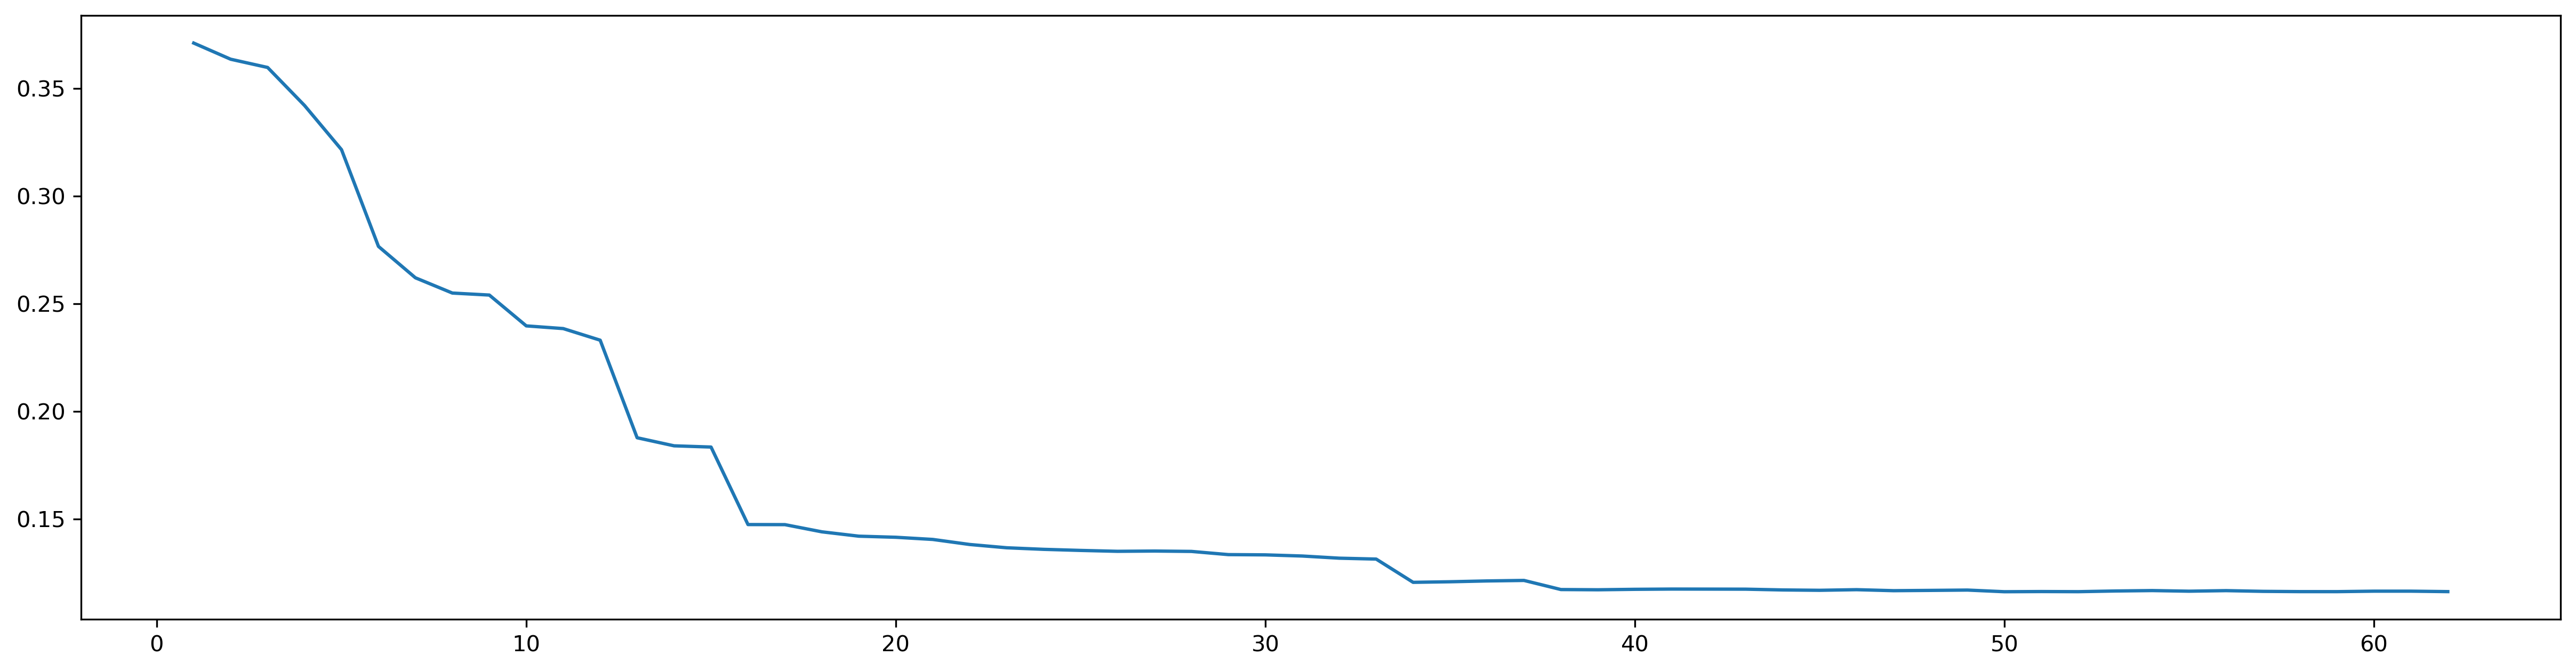

In [48]:
plt.figure(figsize=(20, 5), dpi=300)
plt.plot(range(1, indices.size + 1), scores)
plt.show()

In [49]:
np.argmin(scores) + 1

50

The minimum is achieved at 50 features.

## Selection of regressor

We train our regressor with the top 50 features on the whole train set and evaluate its quality on the test set.

In [50]:
regressor = TransformedTargetRegressor(make_pipeline(
    xgb_regressor.regressor['column_transformer'],
    ColumnTransformer([('selector', 'passthrough', indices[:np.argmin(scores) + 1])]),
    xgb_regressor.regressor['xgb_regressor']
), func=np.log, inverse_func=np.exp)

In [51]:
houses_test = pd.read_pickle('data/king_county_test.pickle')

preprocessor_clean = joblib.load('objects/preprocessor_clean.joblib')
preprocessor_engineer = joblib.load('objects/preprocessor_engineer.joblib')
preprocessor = make_pipeline(preprocessor_clean, preprocessor_engineer)

houses_test = preprocessor.transform(houses_test)
y_test = houses_test['price'].values

In [52]:
regressor.fit(houses_train, y_train)
print_evaluation(regressor, houses_train, houses_test, y_train, y_test)

R^2:   0.970, 0.888
RMSE:  63893, 123061
MAE:   38271, 63512
MedAE: 23947, 36568
MAPE:  0.073, 0.117


On the test set, the mean absolute percentage error is about 11.7% and the median absolute error is about $ 36,600.